In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pykalman import KalmanFilter

2021-12-06 13:48:09.639430: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 13:48:09.639506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# file = pd.read_csv("AAPL_price.csv", dtype={"Close" : np.float64, "Open":np.float64, "High":np.float64, "Low":np.float64, "Volume":np.float64})
# dataframe = file.iloc[1:, :] #Delete first row
data = pd.read_csv("AAPL_price.csv")
data.head()

,Date,Close,Open,High,Low,Volume
0,1980-12-12,0.13,0.13,0.13,0.13,469030000.0
1,1980-12-15,0.12,0.12,0.12,0.12,175880000.0
2,1980-12-16,0.11,0.11,0.11,0.11,105730000.0
3,1980-12-17,0.12,0.12,0.12,0.12,86440000.0
4,1980-12-18,0.12,0.12,0.12,0.12,73450000.0


In [4]:
#Data Cleaning
# Check the percentage of the missing data from the given dataset
# If missing data is less than 5% --> Remove the missing values
# Else --> Impute missing data with midpoint of nearby data
missing_count = data.isnull().sum() / data.count()
if missing_count.Close < 0.05: 
	data.dropna(inplace=True)
else:
	data = data.interpolate() # Takes the midpoint between the points

# Ensure there are no duplicates
data.drop_duplicates(subset='Date', inplace=True)
# print(data.count())

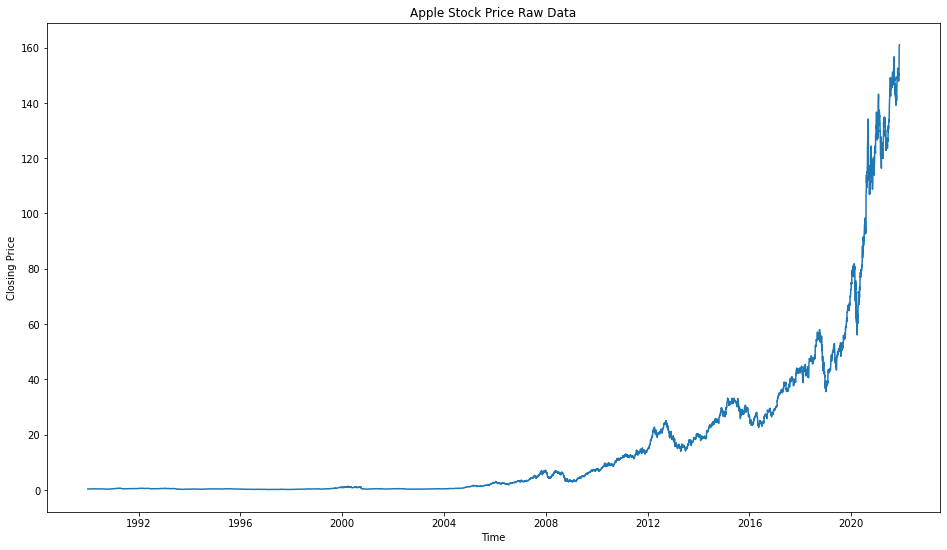

In [5]:
# Test (1990 이후 데이터만 다룸)
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data = data.loc[data['year'] >= 1990]

# Graph raw data
plt.figure(figsize=(16, 9))
plt.plot(data['Date'], data['Close'])
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Apple Stock Price Raw Data')
plt.show()
# plt.savefig('raw_data.png')

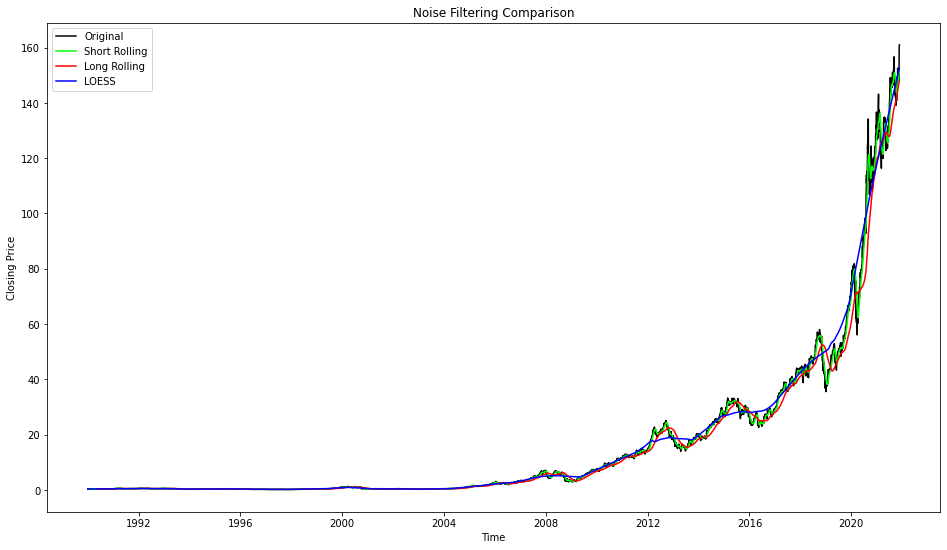

In [6]:
## Noise Filtering
# Rolling mean
short_rolling = data.shift(-1).rolling(window=20).mean()
long_rolling = data.shift(-1).rolling(window=100).mean()

plt.figure(figsize=(16, 9))
plt.plot(data['Date'], data['Close'], color='black', linewidth=1.5)	# Original data
plt.plot(data['Date'], short_rolling['Close'], color='lime', label='20-days SMA')
plt.plot(data['Date'], long_rolling['Close'], color='red', label='100-days SMA')

# LOESS
filtered = lowess(data['Close'], data['Date'], frac=0.05)
plt.plot(data['Date'], filtered[:, 1], 'r-', color='blue')

plt.legend(['Original', 'Short Rolling', 'Long Rolling', 'LOESS'])
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Noise Filtering Comparison')
plt.show()
# plt.savefig('noise_filtering.png')

0.998464620051193
0.994834258077416


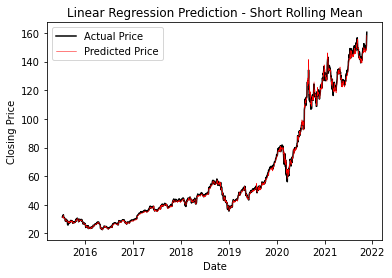

In [7]:
## Machine Learning: Regression Models

# Linear Regression
data['short_rolling'] = data['Close'].shift(-1).rolling(window=20).mean()
# data['long_rolling'] = data.shift(1).rolling(window=100).mean()
data.dropna(inplace=True) # Short rolling

X = data[['Open', 'High', 'Low', 'Volume']]
y = data['short_rolling']
# y = data['Long_Rolling_Mean']
t = int(0.8*len(data))
X_train = X[:t]
X_test = X[t:]
y_train = y[:t]
y_test = y[t:]

# Check why this produce different result
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

lin_model = make_pipeline(
    MinMaxScaler(),
    LinearRegression()
)
lin_model.fit(X_train, y_train)
predictions = lin_model.predict(X_test) # Predict a model
print(lin_model.score(X_train, y_train)) 
print(lin_model.score(X_test, y_test)) 

# Making DataFrame for the predictions & Joining
predictions = pd.DataFrame(predictions, index=y_test.index, columns=['Linear_pred'])
join_pred = data.join(predictions, how='inner')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(join_pred['Date'], join_pred['Close'], color=(0,0,0), label='Actual Price')
ax.plot(join_pred['Date'], join_pred['Linear_pred'], color=(1,0,0), linewidth=0.5, label='Predicted Price')
ax.set_title('Linear Regression Prediction - Short Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend(loc='upper left')
ax.figure.show()
# ax.figure.savefig('linear_regression_prediction.png')

0.9986481559017618
-0.590087884829851


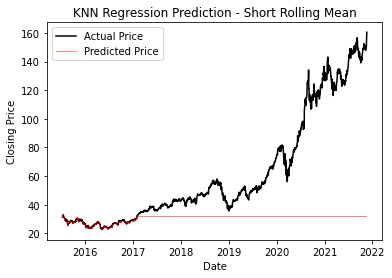

In [10]:
## KNN Regression
# Training & Test data defined above already
knn_model = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=5)
)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test) # Predict a model
print(knn_model.score(X_train, y_train)) 
print(knn_model.score(X_test, y_test)) 

# Making DataFrame for the predictions & Joining
knn_pred = pd.DataFrame(knn_pred, index=y_test.index, columns=['Knn_pred'])
join_pred = data.join(knn_pred, how='inner')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(join_pred['Date'], join_pred['Close'], color=(0,0,0), label='Actual Price')
ax.plot(join_pred['Date'], join_pred['Knn_pred'], color=(1,0,0), linewidth=0.5, label='Predicted Price')
ax.set_title('KNN Regression Prediction - Short Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend(loc='upper left')
ax.figure.show()
# ax.figure.savefig('linear_regression_prediction.png')

0.998842878462967
-0.589076257888185


C:\Users\KAI\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


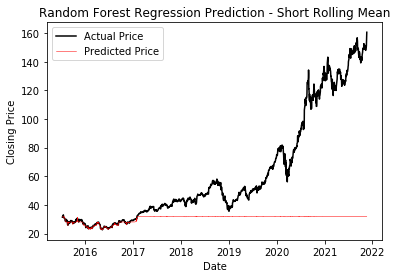

In [13]:
## Random Forest Regression
# Training & Test data defined above already
rf_model = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=20)
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test) # Predict a model
print(rf_model.score(X_train, y_train)) # Short - 0.997828, Long - 0.987426
print(rf_model.score(X_test, y_test)) # Short - 0.992788, Long - 0.966242

# Making DataFrame for the predictions & Joining
rf_pred = pd.DataFrame(rf_pred, index=y_test.index, columns=['rf_pred'])
join_pred = data.join(rf_pred, how='inner')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(join_pred['Date'], join_pred['Close'], color=(0,0,0), label='Actual Price')
ax.plot(join_pred['Date'], join_pred['rf_pred'], color=(1,0,0), linewidth=0.5, label='Predicted Price')
ax.set_title('Random Forest Regression Prediction - Short Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend(loc='upper left')
ax.figure.show()
# ax.figure.savefig('linear_regression_prediction.png')

In [15]:
closePrice = data.Close.astype("float32")
train = closePrice[0:int(len(closePrice)*0.8)]

In [17]:
# plt.figure(figsize=(16,6))
# plt.title('Close Price History')
# plt.plot(file['Close'])
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.show()

In [18]:
#Data normalization
#We have to sacle our data for optimal performance
sc = MinMaxScaler(feature_range = (-1,1))
training_set_scaled = sc.fit(train.values.reshape(-1,1))
closePrice = sc.transform(closePrice.values.reshape(-1,1))


In [19]:
'''
Our train data will have as features the look back values, which are the lag values noted as ‘lb’.
For this example, we set the lb equal to 10. Notice that we scale the data on the “train” dataset
using the MinMaxScaler() from scikit-learn. Finally, for this example, we keep as train dataset
the first 90% of the observations and as a test dataset the rest 10%
'''
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(closePrice,lb)
X,y = processData(closePrice,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

7205 10
801 10
7205
801


In [40]:
#Need to install Tensorflow
#pip install --upgrade tensorflow
#pip install keras
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1,))
model.compile(optimizer='adam',loss='mse', metrics=('acc'))

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),shuffle=True)
model.summary() 


Epoch 1/20
226/226 [==============================] - 7s 23ms/step - loss: 0.0119 - acc: 0.0000e+00 - val_loss: 1.3765 - val_acc: 0.0000e+00
Epoch 2/20
226/226 [==============================] - 5s 21ms/step - loss: 6.8463e-04 - acc: 0.0000e+00 - val_loss: 0.3461 - val_acc: 0.0000e+00
Epoch 3/20
226/226 [==============================] - 5s 21ms/step - loss: 7.7934e-04 - acc: 0.0000e+00 - val_loss: 0.2980 - val_acc: 0.0000e+00
Epoch 4/20
226/226 [==============================] - 5s 21ms/step - loss: 7.8371e-04 - acc: 0.0000e+00 - val_loss: 0.2055 - val_acc: 0.0000e+00
Epoch 5/20
226/226 [==============================] - 5s 22ms/step - loss: 7.0672e-04 - acc: 0.0000e+00 - val_loss: 0.0427 - val_acc: 0.0000e+00
Epoch 6/20
226/226 [==============================] - 5s 22ms/step - loss: 5.8041e-04 - acc: 0.0000e+00 - val_loss: 0.1070 - val_acc: 0.0000e+00
Epoch 7/20
226/226 [==============================] - 5s 21ms/step - loss: 5.8897e-04 - acc: 0.0000e+00 - val_loss: 0.1974 - val_acc: 

Text(0.5, 1.0, 'Train Dataset')

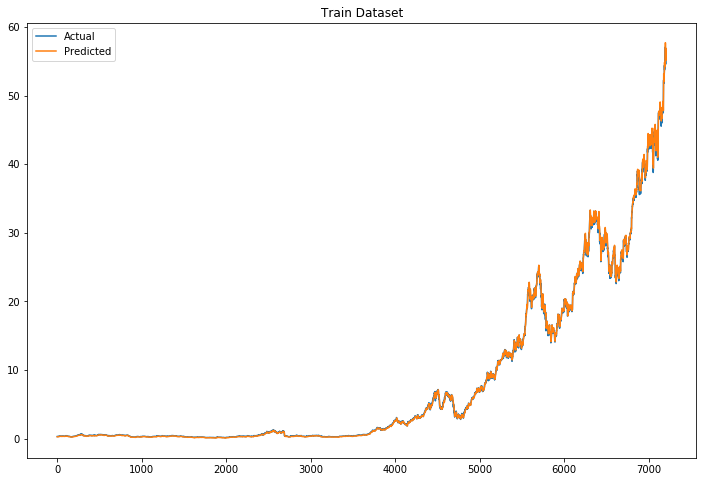

In [42]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_train)
plt.plot(sc.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(sc.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

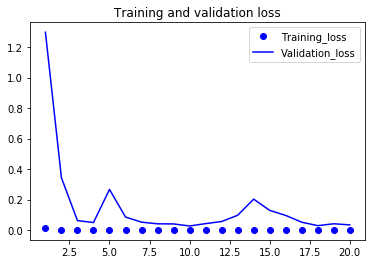

The accuracy is [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [36]:
#Loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training_loss")
plt.plot(epochs, val_loss, "b", label = "Validation_loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

print("The accuracy is {}".format(val_accuracy))
print(history.history.keys())
# print(history.history["acc"])